# Mobilenet

## Sơ lược

**MobileNet áp dụng kiến trúc tích chập tách biệt chiều sâu (Depthwise Separable Convolution).**

Các model như Alexnet hay VGGNetlà những mô hình điển hình có số lượng tham số rất lớn do chỉ áp dụng những tích chập 2 chiều thông thường.

Mobilenet khắc phục nhược điểm này bằng cách áp dụng kiến trúc tích chập tách biệt chiều sâu.

**Phương pháp tích chập 2 chiều thông thường**
![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic1.png)



**Phương pháp tích chập tách biệt chiều sâu**

Độ sâu là một trong những nguyên nhân chính dẫn tới sự gia tăng số lượng tham số của mô hình. **Tích chập tách biệt chiều sâu** sẽ tìm cách loại bỏ sự phụ thuộc vào độ sâu khi tích chập mà vẫn tạo ra được một output shape có kích thước tương đương so với tích chập thông thường. Cụ thể quá trình sẽ được chia thành hai bước tuần tự:

**-Tích chập chiều sâu (Depthwise Convolution)**: Chúng ta sẽ chia khối input tensor3D thành những lát cắt ma trận theo độ sâu. Thực hiện tích chập trên từng lát cắt như hình minh họa bên dưới.

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic2.png)
Mỗi một channel sẽ áp dụng một bộ lọc khác nhau và hoàn toàn không chia sẻ tham số. Điều này có ba tác dụng chính cho mô hình:
-  Nhận diện đặc trưng: Quá trình học và nhận diện đặc trưng sẽ được tách biệt theo từng bộ lọc. Nếu đặc trưng trên các channels là khác xa nhau thì sử dụng các bộ lọc riêng cho channel sẽ chuyên biệt hơn trong việc phát hiện các đặc trưng. Chẳng hạn như đầu vào là ba kênh RGB thì mỗi kênh áp dụng một bộ lọc khác nhau chuyên biệt.

-  Giảm thiểu khối lượng tính toán: Để tạo ra một điểm pixel trên output thì tích chập thông thường cần sử dụng $k*k*c$ phép tính trong khi tích chập chiều sâu tách biệt chỉ cần $k*k$ phép tính. 

-  Giảm thiếu số lượng tham số : Ở tích chập chiều sâu cần sử dụng $c*k*k$ tham số. Số lượng này ít hơn gấp $c'$ lần so với tích chập chiều sâu thông thường. 

**-Tích chập điểm (Pointwise Convolution)**: Có tác dụng thay đổi độ sâu của output bước trên từ $c$ sang $c'$. Chúng ta sẽ áp dụng $c'$ bộ lọc kích thước $1*1*c$. Như vậy kích thước width và height không thay đổi mà chỉ độ sâu thay đổi.

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic3.png)

Kết quả sau cùng chúng ta thu được là một output có kích thước $h'*w'*c'$. Số lượng tham số cần áp dụng ở trường hợp này là $c'*c$.

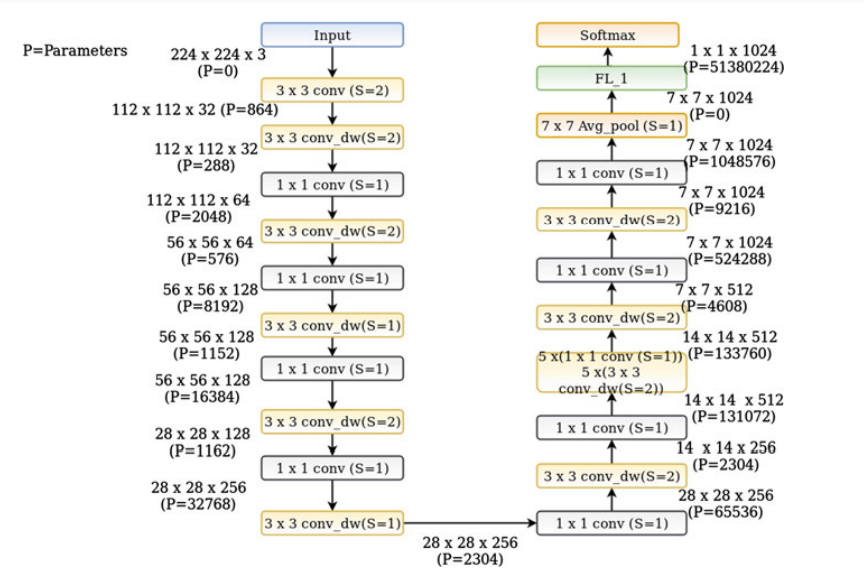



##Tích chập chiều sâu trên Tensorflow


**Trên tensorflow chúng ta có thể thực hiện tích chập chiều sâu tách biệt theo hai bước tuần tự là:**
*  **Tích chập chiều sâu**: Sử dụng hàm `tf.keras.layers.DepthwiseConv2D()` với *depth_multiplier = 1* đại diện cho độ sâu được tích chập.

*  **Tích chập điểm**: Sử dụng hàm `tf.keras.layers.Conv2D()` với kích thước *kernel_size = 1*.

In [ ]:
import tensorflow as tf
import numpy as np
x = np.random.randn(10, 15, 15, 20) # Batch_size, W, H, C
x = x.astype('float32')
def depthwise_separable_conv_tf(x):
  dw2d = tf.keras.layers.DepthwiseConv2D(
      kernel_size=3, strides=1, padding='same', depth_multiplier=1
  )
  pw2d = tf.keras.layers.Conv2D(
      filters=50, kernel_size=1, strides=1
  )
  y = dw2d(x)
  y = pw2d(y)
  return y
y = depthwise_separable_conv_tf(x)  
y.shape # Batch_size, W, H, C

TensorShape([10, 15, 15, 50])

## Tích chập chiều sâu trên Pytorch

Module `torch.nn.Conv2d()` cho phép cấu hình độ sâu của tích chập thông qua tham số groups. 

Kích thước của độ sâu sẽ bằng *input channels/groups*. Mặc định của tham số này là *groups = 1*. Khi đó toàn bộ độ sâu sẽ là một nhóm và tích chập được tính trên toàn bộ độ sâu.

Nếu muốn sử dụng tích chập theo chiều sâu thì thiết lập *groups = input channels*. Khi đó độ sâu sẽ được chia thành *input channels* nhóm, mỗi nhóm có kích thước là 1.

In [ ]:
from torch import nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(Depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


x = torch.randn(10, 20, 15, 15) # Batch_size, C, W, H
y = DepthwiseSeparableConv(nin=20, nout=50)(x)
y.size()

# MobileNet V2

MobileNetV2 có một số điểm cải tiến so với MobileNetV1 giúp cho nó có độ chính xác cao hơn, số lượng tham số và số lượng các phép tính ít hơn.

## Inverted Residual Block (Khối dư đảo ngược)


MobileNetV2 cũng sử dụng những kết nối tắt như ở mạng ResNet. Các khối ở layer trước được cộng trực tiếp vào layer liền sau.

Nếu coi *layer* liền trước là $x$, sau khi đi qua các xử lý tích chập hai chiều ta thu được kết quả $F(x)$ thì output cuối cùng là một *residual block* có giá trị $x + F(x)$.

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic4.jpeg)

Tuy nhiên kết nối tắt ở MobileNetV2 được điều chỉnh sao cho số kênh (hoặc chiều sâu) ở *input* và *output* của mỗi *block residual* được thắt hẹp lại. Chính vì thế nó được gọi là các **bottleneck layers** (*bottleneck* là một thuật ngữ thường được sử dụng trong deep learning để ám chỉ các kiến trúc thu hẹp kích thước theo một chiều nào đó).

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic4.png)

Kiến trúc *residual* này ngược lại so với các kiến trúc *residual* truyền thống vì kiến trúc *residual* truyền thống có số lượng kênh ở *input* và *output* của một *block* lớn hơn so với các *layer* trung gian. Chính vì vậy nó còn được gọi là kiến trúc **inverted residual block**.

## Loại bỏ non-linear

Trong thực nghiệm, việc sử dụng các biến đổi phi tuyến (như biến đổi qua ReLu hoặc sigmoid) tại *input* và *output* của các *residual block* sẽ làm cho thông tin bị mất mát.

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic5.png)

Chính vì thế trong kiến trúc của *residual block* tác giả đã loại bỏ hàm phi tuyến tại layer *input* và *output* và thay bằng các phép chiếu tuyến tính.

## Khởi tạo Inverted Residual Block

### Trên Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np

x = np.random.randn(10, 64, 64, 16)
x = x.astype('float32')

def inverted_linear_residual_block(x, expand=64, squeeze=16):
  '''
  expand: số lượng channel của layer trung gian
  squeeze: số lượng channel của layer bottleneck input và output
  '''
  # Depthwise convolution
  m = tf.keras.layers.Conv2D(expand, (1,1), padding='SAME', activation='relu')(x)
  m = tf.keras.layers.DepthwiseConv2D((3,3), padding='SAME', activation='relu')(m)
  # Pointwise convolution + Linear projection
  m = tf.keras.layers.Conv2D(squeeze, (1,1), padding='SAME', activation='linear')(m)
  opt = tf.keras.layers.Add()([m, x])
  return opt

y = inverted_linear_residual_block(x, expand=64, squeeze=16)
y.shape

TensorShape([10, 64, 64, 16])

Trong kiến trúc này chúng ta sử dụng lần lượt:

*  Tích chập 2 chiều với *kernel=(1, 1)*, số kênh của *output* được mở rộng để tạo thành *layer* trung gian.

*  Tích chập chiều sâu `(DepthwiseConv2D)` với *kernel=(3, 3)* có tác dụng trích lọc đặc trưng. Ở `DepthwiseConv2D` chúng ta sẽ không khai báo số kênh vì tích chập chiều sâu trả ra số kênh bằng với *input* trước đó.

*  Tích chập 2 chiều với *kernel=(1, 1)* có số kênh giảm xuống để tạo thành *output* cho *block residual*.

### Trên Pytorch

In [ ]:
import torch
from torch import nn

class InvertedLinearResidualBlock(nn.Module):
    def __init__(self, expand=64, squeeze=16):
        '''
        expand: số lượng channel của layer trung gian
        squeeze: số lượng channel của layer bottleneck input và output
        '''
        super(InvertedLinearResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            # Depthwise Convolution
            nn.Conv2d(squeeze, expand, kernel_size=3, stride=1, padding=1, groups=squeeze, bias=False),
            nn.ReLU6(inplace=True),
            # Pointwise Convolution + Linear projection
            nn.Conv2d(expand, squeeze, kernel_size=1, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        return x + self.conv(x)
        
x = torch.randn(10, 16, 64, 64) # Batch_size, C, W, H
y = InvertedLinearResidualBlock(expand=64, squeeze=16)(x)
y.size()

torch.Size([10, 16, 64, 64])

Trên pytorch thì tích chập chiều sâu tách biệt có thể được thực hiện ngay trên chính một layer `Conv2d` thông qua cấu hình tham số *groups*.

Ngoài ra chúng ta lưu ý các thay đổi so với MobilenetV1 đó là: biến đổi tại layer *output* đã được thay bằng *linear projection* (phép chiều tuyến tính) và độ sâu của các layer trung gian sâu hơn so với *layer input* và *output*.

# MobileNet V3

Thêm **Squeeze and Excitation (SE)** vào *Residual block* để tạo thành một kiến trúc có độ chính xác cao hơn.

![image](https://phamdinhkhanh.github.io/assets/images/20200914_Mobilenet/pic7.png)

Nhánh Squeeze and Excitation có kích thước (width x height) bằng 1 x 1 lần lượt đi qua các biến đổi FC -> Relu -> FC -> hard sigmoid. Cuối cùng được nhân trực tiếp vào nhánh input để scale input theo global context. Các kiến trúc còn lại hoàn toàn giữ nguyên như MobileNetV2.